### 9.5 Dịch máy và tập dữ liệu

- Đến nay ta đã thấy cách sử dụng mạng nơ ron hồi tiếp cho các mô hình ngôn ngữ, mà ở đó ta dự đoán token tiếp theo kho đã biết tất cả các token trước đó. Bây giờ ta sẽ xem xét một ứng dụng khác để dự đoán một chuỗi token thay vì chỉ một token đơn lẻ.

- Dịch máy (Machine translation) đề cập đến việc dịch tự động một đoạn văn bản từ ngôn ngữ này sang ngôn ngữ khác. Giải quyết bài toán này với các mạng nơ ron thông thường được gọi là dịch máy nơ ron. So với các mô hình ngôn ngữ, khoi ngữ liệu chỉ chứa một ngôn ngữ duy nhất, bộ dữ liệu dịch máy có ít nhất hai ngôn ngữ: Ngôn ngữ nguồn và ngôn ngữ đích. Ngoài ra, mỗi câu trong ngôn ngữ nguồn sẽ được ánh xạ tới bản dịch tương ứng trong ngôn ngữ đích. Do đó, cách tiền xử lý dữ liệu dịch máy sẽ khác so với mô hình ngôn ngữ. Phần này được dành riêng để trình bày cách tiền xử lý và nạp một tập dữ liệu như vậy vào các minibatch.

In [44]:
from d2l import torch as d2l
from torch import nn
import torch
import os
import numpy as np

#### 9.5.1 Tải và tiền xử lý dữ liệu
- Trước tiên, ta tải xuống bộ dữ liệu chứa một tập các câu tiếng Anh cùng với các bản dịch tiếng Pháp tương ứng. Có thể thấy mỗi dùng chứa một câu tiếng Anh cùng với bản dịch tiếng Pháp tương ứng, cách nhau bởi một dấu TAB.

In [45]:
class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

In [46]:
data = MTFraEng()
raw_text = data._download()

In [47]:
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



raw_text[:75]

In [48]:
len(raw_text)

11489286

In [49]:
@d2l.add_to_class(MTFraEng)
def _preprocess(self, text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    result = []
    for i in range(0, len(text)):
        if (i == 0):
            result.append(text[i])
            continue
        char, prev_char = text[i], text[i - 1]
        if (prev_char != ' ' and char in ',.?!'):
            result.append(' ')
        result.append(char)
    return ''.join(result)

In [50]:
text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


#### 9.5.2 Token hóa
- Khác với việc sử dụng ký tự làm token, ở đây token là một từ hoặc dấu câu. Hàm sau đây sẽ token hóa dữ liệu văn bản để trả về source và target là hai danh sách chứa các danh sách token, với __source[i]__ là câu thứ i trong ngôn ngữ nguồn và target[i] là câu thứ i trong ngôn ngữ đích. Để việc huấn luyện sau này nhanh hơn, chúng ta chỉ lấy mẫu num_examples cặp câu đầu tiên.

In [51]:
@d2l.add_to_class(MTFraEng)
def _tokenize(self, text, num_examples = None):
    source, target = [], []
    text = text.lower()
    for i, line in enumerate(text.split('\n')):
        if num_examples is not None and i >= num_examples:
            break
        line = line.split("\t")
        # print(f"Line: {i} -> {line}")
        if len(line) == 2:
            source.append(line[0].split(" "))
            target.append(line[1].split(" "))
    return source, target
    
source, target = data._tokenize(text)
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

In [52]:
from matplotlib import pyplot as plt

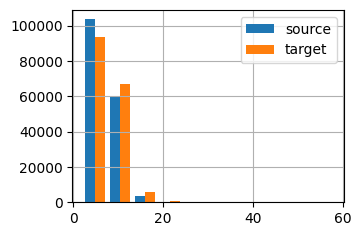

In [53]:
plt.figure(figsize = (3.5, 2.5))
plt.hist([[len(l) for l in source], [len(l) for l in target]], label = ['source', 'target'])
plt.grid(True)
plt.legend()
plt.show()

- Đây là biểu đồ tần suất cho số lượng token trong câu, có thể thấy trung bình một câu chứa 5 token và hầu hết các câu có ít hơn 10 token.

#### 9.5.3 Bộ từ vựng
- Vì các token trong ngôn ngữ nguồn có thể khác với các token trong ngôn ngữ đích, ta cần xây dựng một bộ từ vựng cho mỗi ngôn ngữ. Do ta đang sử udngj các từ để làm token chứ không dùng ký tự, kích thước bộ từ vựng sẽ lớn hơn đáng kể. Ở đây ta sẽ ánh xạ mọi token xuất hiện ít hơn 3 lần vào token __unk__. Ngoài ra, ta cần các token đặc biệt khác như token đệm __pad__, hay token bắt đầu câu __bos__.

In [54]:
src_vocab = d2l.Vocab(source, min_freq = 3, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

7939

In [55]:
print(src_vocab.idx_to_token)

['!', '!"', '"a', '"are', '"because', '"can', '"do', '"does', '"have', '"how', '"i', '"i\'d', '"i\'ll', '"i\'m', '"in', '"is', '"it', '"it\'s', '"let\'s', '"may', '"neither', '"no', '"not', '"nothing', '"says', '"so', '"sure', '"thank', '"thanks', '"that\'s', '"the', '"they', '"tom', '"what', '"what\'s', '"when', '"where', '"where\'s', '"who', '"why', '"will', '"yes', '"you', '"you\'re', '$1', '$10', '$100', '$2', '$3', '$30', '$300', '$500', "'em", ',', ',"', ',000', '.', '."', '.d', '.m', '.s', '1', '10', '10%', '100', '100%', '10:00', '11', '11:00', '12', '123', '13', '130', '15', '150', '16', '1650', '16th', '17', '17th', '18', '1814', '1935', '1939', '1945', '1950', '1954', '1957', '1960', '1970', '1972', '1975', '1980', '1990', '1995', '19th', '1st', '2', '20', '200', '2003', '2013', '20th', '215', '21st', '23', '24', '25', '25th', '26', '28', '2:30', '3', '30', '300', '4', '40', '45', '4:00', '4:30', '5', '50', '500', '6', '60', '65', '6:30', '7', '70', '7:00', '7:30', '8', '80'

#### 9.5.4 Nạp dữ liệu
- Trong các mô hình ngôn ngữ, mỗi mẫu là một chuỗi có độ dài __num_steps__ từ kho ngữ liệu mà có thể là một phân đoạn của một câu hoặc trải dài trên nhiều câu. Trong dịch máy, một mẫu bao gồm một cặp câu nguồn và một cặp câu đích. Những câu này có thể có độ dài khác nhau, trong khi đó, ta cần các mẫu có cùng độ dài để tạo minibatch.

- Một cách giải quyết vấn đề này là nếu một câu dài hơn __num_steps__, ta sẽ cắt bớt độ dài của nó, ngược lại nếu một câu ngắn hơn __num_steps__, ta sẽ thêm đệm token __pad__. Bẳng cách này, ta sẽ có thể chuyển bất kỳ câu nào về độ dài cố định.

In [56]:
@d2l.add_to_class(MTFraEng)
def truncate_pad(self, line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token] * (num_steps - len(line))

data.truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[3119, 56, 141, 141, 141, 141, 141, 141, 141, 141]

- Bây giờ ta có thể chuyển đổi danh sách các câu thành mảng chỉ số có kích thước (num_example, num_steps). Ta cũng ghi lại độ dài của mỗi câu khi không có token đệm, được gọi là độ dài hợp lệ - valid length. Thông tin này có thể được sử dụng bởi một sô mô hình. 
- Ngoài ra, ta sẽ thêm các token đặc biệt __bos__ và __eos__ vào các câu đích để mô hình biết thời điểm bắt đầu và kết thúc dự đoán.

In [57]:
print(source[:10])

[['go', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!'], ['fire', '!'], ['help', '!'], ['jump', '.'], ['stop', '!']]


In [58]:
@d2l.add_to_class(MTFraEng)
def build_array(self, lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if is_source == False:
        lines = [[vocab["<bos>"]] + l + [vocab['<eos>']] for l in lines]
    
    array = np.array([self.truncate_pad(
        l, num_steps, vocab["<pad>"]
    ) for l in lines])

    valid_len = (array != vocab['<pad>']).sum(axis = 1)

    return torch.from_numpy(array), torch.from_numpy(valid_len)
data.build_array(source, src_vocab, 10, True)

(tensor([[3119,   56,  141,  ...,  141,  141,  141],
         [3402,   56,  141,  ...,  141,  141,  141],
         [5954,    0,  141,  ...,  141,  141,  141],
         ...,
         [6307, 7054,  496,  ...,  435, 3104, 7191],
         [3575, 6468, 7756,  ..., 6024, 7041, 7915],
         [3826, 4337,  735,  ..., 1514,  142, 1673]], dtype=torch.int32),
 tensor([ 2,  2,  2,  ..., 10, 10, 10], dtype=torch.int32))

In [59]:
@d2l.add_to_class(MTFraEng)
def __init__(self, batch_size, num_steps = 9, num_train = 512, num_val = 128, min_freq = 3):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    text = self._preprocess(self._download())
    self.source, self.target = self._tokenize(text)

    self.src_vocab = d2l.Vocab(self.source, min_freq, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    self.target_vocab = d2l.Vocab(self.target, min_freq, reserved_tokens=['<pad>', '<bos>', '<eos>'])

    self.src_array, self.src_valid_len = self.build_array(self.source, self.src_vocab, num_steps, True)
    self.target_array, self.target_valid_len = self.build_array(self.target, self.target_vocab, num_steps, False)

    # self.arrays = (self.src_array, self.src_valid_len, self.target_array, self.target_valid_len)
    self.arrays = (self.src_array, self.target_array[:, :-1], self.src_valid_len, self.target_array[:, 1:])
@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train : bool):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

@d2l.add_to_class(MTFraEng)
def build(self, src_sentences, target_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, target_sentences)])
    text = self._preprocess(raw_text)
    source, target = self._tokenize(text)

    src_array, _ = self.build_array(source, self.src_vocab, self.num_steps, True)
    tgt_array, _ = self.build_array(target, self.target_vocab, self.num_steps, False)

    return src_array, tgt_array


In [60]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))


In [61]:
print("###### SOURCE: #######")
print(src)
for l in src.numpy():
    print(data.src_vocab.to_tokens(l))

print("\n##### TARGET: ######")
print('decoder input:', tgt)
for l in tgt.numpy():
    print(data.target_vocab.to_tokens(l))

print('\nsource len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

###### SOURCE: #######
tensor([[3119,  638,   56,  141,  141,  141,  141,  141,  141],
        [ 653, 4785,   56,  141,  141,  141,  141,  141,  141],
        [ 735, 4671,   56,  141,  141,  141,  141,  141,  141]],
       dtype=torch.int32)
['go', 'away', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['back', 'off', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['be', 'nice', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

##### TARGET: ######
decoder input: tensor([[   96, 12571, 12008,  4605,  4977,     1,    97,    98],
        [   96,    99,     1,    97,    98,    98,    98,    98],
        [   96, 11555,  5177,     1,    97,    98,    98,    98]],
       dtype=torch.int32)
['<bos>', 'va', 'te', 'faire', 'foutre', '!', '<eos>', '<pad>']
['<bos>', '<unk>', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'soyez', 'gentil', '!', '<eos>', '<pad>', '<pad>', '<pad>']

source len excluding pad: tensor([3, 3, 3], dtype=torch.int32)
label:

In [63]:
src, tgt = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.target_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
